In [22]:
# LIB UPLOAD CELL:
###########################################

import MAIN_MODULE as mm


path_main = '/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/qRC/'
path_EVAL = path_main + 'EVALUATION/BRIDGEOFF_STM_60/'
path_PRODUCT =  path_EVAL + 'PRODUCTION/'
mm.sys.path.append(path_main)

from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca


In [2]:
# EVALUATION CELL:
###########################################
num_signal_samples = 60
num_states_samples = 60
multiplexing = 10

# FUNCTION EVALUATE IMPLEMENT ANALYSIS WITH  BRIDGE SET TO OFF !!!
def evaluate_bridge_off(init_state, signal, depolarization_prob):
    # Initialization
    inp = signal[2000:2200]
    result = mm.np.zeros((len(inp), multiplexing, mm.n_qubitsB))
    state = init_state
    # PRECPROCESSING --> IT IS NECESSARY TO SATISFY ECHO STATE PROPERTY. 2000 temporal preproc. steps.
    for i in range(2000):
        state = mm.encoding_step(state, signal[i])
        state = mm.evolution_step(state)
        #state = mm.entangled_channel_step(state, depolarization_prob) ## ENTANGLING CHANNEL EXEC FUNCTION
        
    # READOUT  ( TEMPORAL MULTIPLEXING )
    for n in range(len(inp)):
        state = mm.encoding_step(state, inp[n])
        for m in range(multiplexing):
            state = mm.evolution_step(state)
            #state = mm.entangled_channel_step(state, depolarization_prob)

            for site in range(mm.n_qubitsB):
                state, outcome = mm.separated_measurement_step(state, site + mm.n_qubitsA)
                result[n, m, site] = outcome

    return result

In [3]:
# EXECUTION CELL:
###########################################

# for s in range(num_signal_samples):
#     print('Signal sample num:' +  str(s))
#     signal = [mm.np.random.choice(2) for _ in range(2200)]
#     for i in mm.tqdm(range(num_states_samples)):
#         # Initial density matrix
#         init_state = mm.qt.tensor(*[mm.qt.rand_ket(2) for _ in range(mm.n_qubits_total)])
#         init_state = init_state * init_state.dag()
#         init_state = init_state.full()
#         results = evaluate_bridge_off(init_state, signal, 0)
#         mm.np.save(path_EVAL + str(s) + 'results' + str(i), results)
#         mm.np.save(path_EVAL + str(s)+'signal', signal)

Signal sample num:0



Signal sample num:1



Signal sample num:2



Signal sample num:3



Signal sample num:4



Signal sample num:5



Signal sample num:6



Signal sample num:7



Signal sample num:8



Signal sample num:9



Signal sample num:10



Signal sample num:11



Signal sample num:12



Signal sample num:13



Signal sample num:14



Signal sample num:15



Signal sample num:16



Signal sample num:17



Signal sample num:18



Signal sample num:19



Signal sample num:20



Signal sample num:21



Signal sample num:22



Signal sample num:23



Signal sample num:24



Signal sample num:25



Signal sample num:26



Signal sample num:27



Signal sample num:28



Signal sample num:29



Signal sample num:30



Signal sample num:31



Signal sample num:32



Signal sample num:33



Signal sample num:34



Signal sample num:35



Signal sample num:36



Signal sample num:37



Signal sample num:38



Signal sample num:39



Signal sample num:40



Signal sample num:41



Signal sample num:42



Signal sample num:43



Signal sample num:44



Signal sample num:45



Signal sample num:46



Signal sample num:47



Signal sample num:48



Signal sample num:49



Signal sample num:50



Signal sample num:51



Signal sample num:52



Signal sample num:53



Signal sample num:54



Signal sample num:55



Signal sample num:56



Signal sample num:57



Signal sample num:58



Signal sample num:59


In [9]:
counter = 0
for s in range(num_signal_samples):
    res = []
    for i  in range(num_states_samples):
        res.append(mm.np.load(path_EVAL + str(s) + 'results' + str(i) + '.npy'))
    res_arr = mm.np.asarray(res)
    res_av = mm.np.mean(res_arr, axis = 0)

    k = mm.np.random.choice(60)
    if mm.np.linalg.norm(res_av.reshape(-1, mm.n_qubitsB)[:, 0] - res[k].reshape(-1, mm.n_qubitsB)[:, 0]) >= 10**-3:
        counter += 1
if counter == 0:
    print ('ECHO STATE PROPOERTY IS ELIGABLE')
else:
    print ('ECHO STATE PROPOERTY FAILED')

ECHO STATE PROPOERTY FAILED


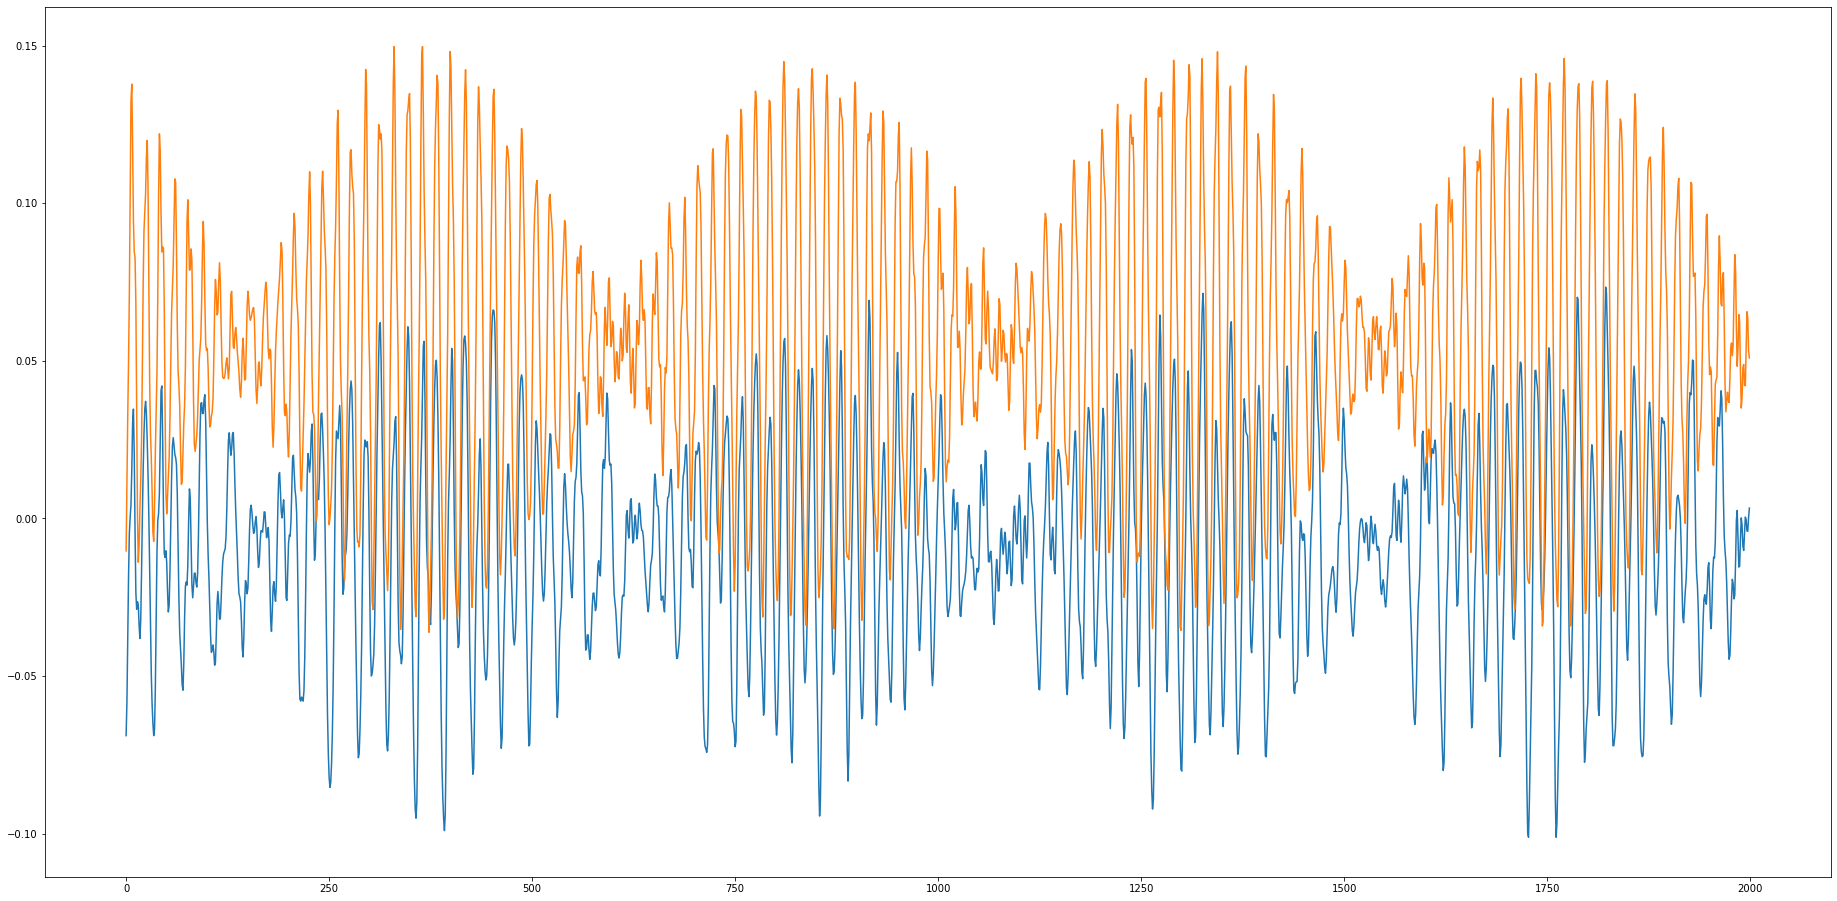